In [140]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout, BatchNormalization
import numpy as np
from tensorflow.keras.optimizers import SGD
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
tf.keras.utils.set_random_seed(32)
tf.config.experimental.enable_op_determinism()


In [141]:

def parse_data(file_path):
    sequences = []
    labels = []
 
    with open(file_path, "r") as file:
        for line in file:
            if line == "end\n" or line == "<end>":
                sequences.append("end")
                labels.append("end")
                #print("End of sequence")
            elif len(line) == 4:
                sequences.append(line[0]) # Amino acid
                labels.append(line[2]) # e, h, _
                          
            else:
                #print("Something else")
                #print(line)
                pass
        
    
    return sequences, labels

def encode_seqeuences(sequences):
    amino_acid_mapping = {
    'A': 0,  'R': 1,  'N': 2,  'D': 3,  'C': 4,
    'Q': 5,  'E': 6,  'G': 7,  'H': 8,  'I': 9,
    'L': 10, 'K': 11, 'M': 12, 'F': 13, 'P': 14,
    'S': 15, 'T': 16, 'W': 17, 'Y': 18, 'V': 19,
    'end': 20
    }
    encoded_seqs = []
    for amino_acid in sequences:
        encoding = [0]*21
        encoding[amino_acid_mapping[amino_acid]] = 1
        encoded_seqs.append(encoding)

    return encoded_seqs

def encode_labels(labels):
    label_mapping = {
    'e': 0, 'h': 1, '_': 2, 'end': 3
    }
    #print("encoding labels")
    encoded_labels = []
    for label in labels:
        encoded_label = [0,0,0]
        if label_mapping[label] != 3:
            encoded_label[label_mapping[label]] = 1
        encoded_labels.append(encoded_label)
    return encoded_labels

    
seq,labels = parse_data("protein-secondary-structure.train.txt")
#print(seq)
eseq = encode_seqeuences(seq)
#print(labels)
elab = encode_labels(labels)


In [142]:
def build_model(input_shape):
    #learning_rate = 0.001
    #optim = Adam(learning_rate=learning_rate)
    model = Sequential([
        Dense(40, activation='sigmoid', input_shape=(input_shape,)),  # Changed to ReLU

        Dense(3, activation='softmax')  # Output layer for the three types of secondary structures
    ])
    model.compile(optimizer=SGD(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model
def create_sliding_windows(encoded_seqs, window_size=13):
    # Padding to handle boundaries
    padding = np.zeros((window_size // 2, 21))  # Zero vectors for padding
    padded_seqs = np.vstack([padding, encoded_seqs, padding])
    
    # Create sliding windows
    windows = np.array([padded_seqs[i:i + window_size].flatten() for i in range(len(encoded_seqs))])
    return windows


In [143]:

windowed_input = create_sliding_windows(np.array(eseq))


# Assuming elab is already one-hot encoded
X_train, X_test, y_train, y_test = train_test_split(windowed_input, elab, test_size=0.2, random_state=42)
# Build the model with the correct input shape
model = build_model(X_train.shape[1])
y_train = np.array(y_train)
y_test = np.array(y_test)

# Train the model
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), batch_size=32)
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test accuracy:", test_accuracy)


Epoch 1/100
455/455 [==============================] - 2s 2ms/step - loss: 1.0049 - accuracy: 0.5313 - val_loss: 0.9861 - val_accuracy: 0.5448
Epoch 2/100
455/455 [==============================] - 1s 2ms/step - loss: 0.9928 - accuracy: 0.5417 - val_loss: 0.9820 - val_accuracy: 0.5448
Epoch 3/100
455/455 [==============================] - 1s 1ms/step - loss: 0.9879 - accuracy: 0.5417 - val_loss: 0.9786 - val_accuracy: 0.5448
Epoch 4/100
455/455 [==============================] - 1s 1ms/step - loss: 0.9834 - accuracy: 0.5417 - val_loss: 0.9739 - val_accuracy: 0.5448
Epoch 5/100
455/455 [==============================] - 1s 1ms/step - loss: 0.9787 - accuracy: 0.5417 - val_loss: 0.9688 - val_accuracy: 0.5448
Epoch 6/100
455/455 [==============================] - 1s 2ms/step - loss: 0.9740 - accuracy: 0.5417 - val_loss: 0.9645 - val_accuracy: 0.5448
Epoch 7/100
455/455 [==============================] - 1s 2ms/step - loss: 0.9690 - accuracy: 0.5417 - val_loss: 0.9606 - val_accuracy: 0.5453

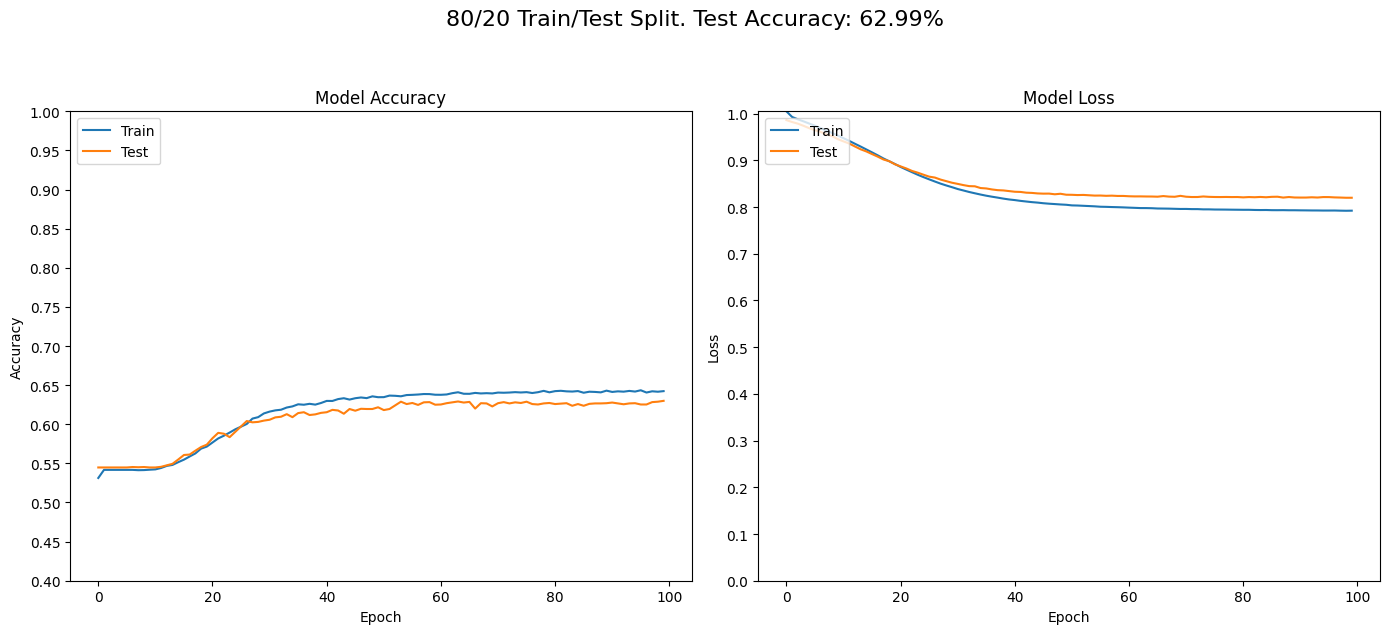

114/114 [==============================] - 0s 876us/step
Q3 Score: 0.6299450549450549


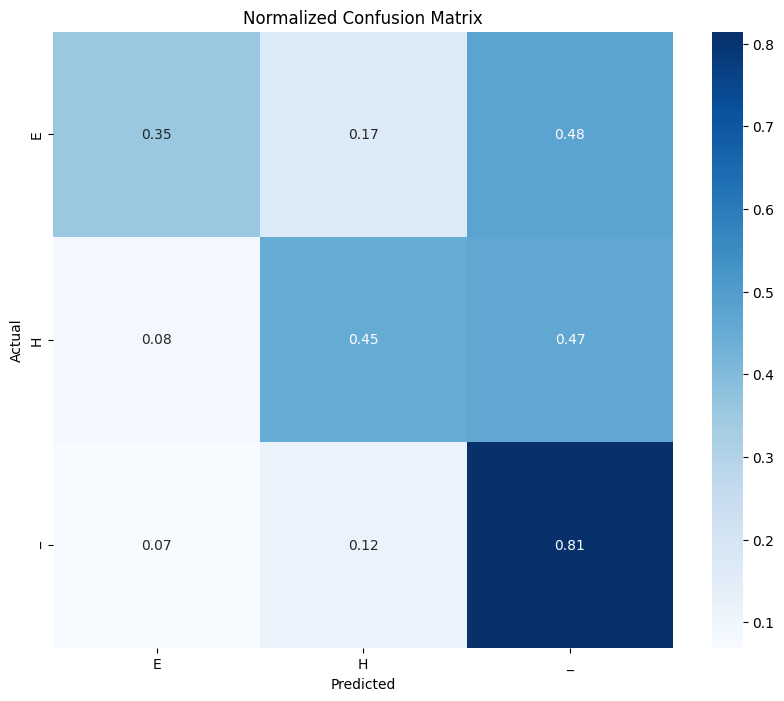

In [144]:
# Plot training & validation accuracy values
plt.figure(figsize=(14, 6))
plt.suptitle('80/20 Train/Test Split. Test Accuracy: ' + str(round(test_accuracy*100,2)) + '%', fontsize=16, y=1.05, x=0.5, ha='center')
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.yticks([i / 20 for i in range(21)])  # 0, 0.1, 0.2, ..., 1.0

plt.ylim(0.4, 1)  # Adjust the y-axis limit to provide space at the top

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.yticks([i / 10 for i in range(11)])  # 0, 0.1, 0.2, ..., 1.0

plt.ylim(0, max(max(history.history['loss']), max(history.history['val_loss'])))  # Adjust y-axis limit dynamically

# Put test accuracy as a label on the plot
# Adjust layout to remove white space
plt.tight_layout()
plt.show()


def calculate_q3_score(y_true, y_pred):
    total = len(y_true)
    correct = sum(np.argmax(y_true[i]) == np.argmax(y_pred[i]) for i in range(total))
    return correct / total

#Give me a confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_test_labels = np.argmax(y_test, axis=1)


q3_score = calculate_q3_score(y_test, y_pred)
print("Q3 Score:", q3_score)
# Compute the normalized confusion matrix
cm = confusion_matrix(y_test_labels, y_pred_labels, normalize='true')

# Plotting the normalized confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt=".2f", cmap='Blues', xticklabels=['E', 'H', '_'], yticklabels=['E', 'H', '_'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Normalized Confusion Matrix')
plt.show()



In [145]:
def save_metrics(model_name, accuracy, confusion_matrix, labels):
    # Save the accuracy to a CSV file
    import pandas as pd
    accuracy_data = pd.DataFrame({
        'Model': [model_name], 
        'Accuracy': [accuracy], 
        'ePercentage' : [confusion_matrix[0][0]], 
        'hPercentage' : [confusion_matrix[1][1]], 
        'blankPercentage' : [confusion_matrix[2][2]]
    })
    accuracy_data.to_csv(f"{model_name}_accuracy.csv", index=False)

    # Plot and save the confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(confusion_matrix, annot=True, fmt=".2f", cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Normalized Confusion Matrix - {model_name}')
    plt.savefig(f"{model_name}_confusion_matrix.png")
    plt.close()

class_labels = ['E', 'H', '_']

# Evaluate the first model
test_accuracy_first = model.evaluate(X_test, y_test)[1]
y_pred_first = model.predict(X_test)
cm_first = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred_first, axis=1), normalize='true')
save_metrics("First_Network", test_accuracy_first, cm_first, class_labels)


114/114 [==============================] - 0s 876us/step


In [146]:
def Model17():
    #Do network with 17 units for the sliding window

    eseq = encode_seqeuences(seq)
    elab = encode_labels(labels)

    windowed_input = create_sliding_windows(np.array(eseq), window_size=17)
    X_train, X_test, y_train, y_test = train_test_split(windowed_input, elab, test_size=0.2, random_state=42)

    create_sliding_windows(eseq, window_size=17)
    model = build_model(X_train.shape[1])
    y_train = np.array(y_train)
    y_test = np.array(y_test)
    # Train the model
    history = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), batch_size=32)
    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    print("Test accuracy:", test_accuracy)

    # Plot training and validation accuracy values
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')

    plt.tight_layout()
    plt.show()

Epoch 1/100
364/364 [==============================] - 2s 2ms/step - loss: 1.0398 - accuracy: 0.5174 - val_loss: 0.8781 - val_accuracy: 0.5714
Epoch 2/100
364/364 [==============================] - 1s 2ms/step - loss: 0.8811 - accuracy: 0.5904 - val_loss: 0.8133 - val_accuracy: 0.6277
Epoch 3/100
364/364 [==============================] - 1s 2ms/step - loss: 0.8596 - accuracy: 0.6002 - val_loss: 0.8105 - val_accuracy: 0.6291
Epoch 4/100
364/364 [==============================] - 1s 2ms/step - loss: 0.8369 - accuracy: 0.6141 - val_loss: 0.8111 - val_accuracy: 0.6236
Epoch 5/100
364/364 [==============================] - 1s 2ms/step - loss: 0.8324 - accuracy: 0.6168 - val_loss: 0.8112 - val_accuracy: 0.6305
Epoch 6/100
364/364 [==============================] - 1s 2ms/step - loss: 0.8273 - accuracy: 0.6187 - val_loss: 0.8115 - val_accuracy: 0.6253
Epoch 7/100
364/364 [==============================] - 1s 2ms/step - loss: 0.8266 - accuracy: 0.6177 - val_loss: 0.8112 - val_accuracy: 0.6264

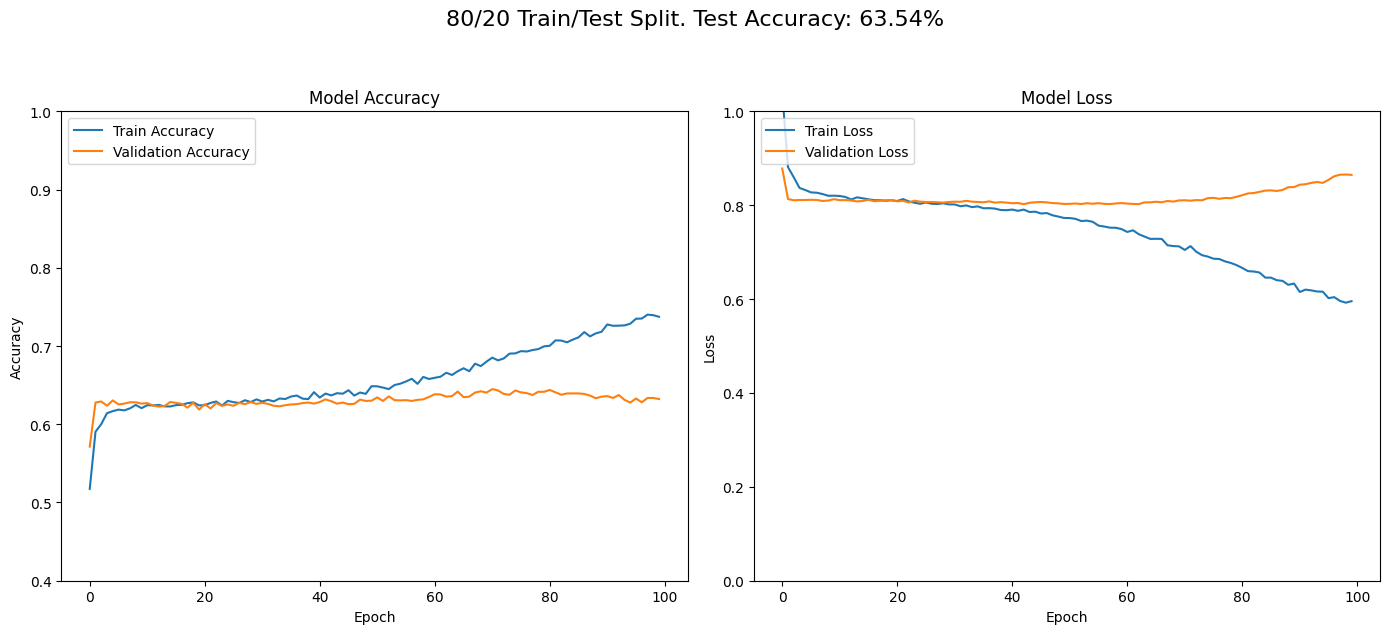

In [150]:

def improved_model(input_shape):
    model = Sequential([
        Dense(40, activation='sigmoid', input_shape=(input_shape,)),  # Changed from sigmoid to ReLU
        BatchNormalization(),  # Normalize the activation from the first layer
        Dropout(0.25),  # Randomly sets input units to 0 with a frequency of 50% at each step during training
        Dense(3, activation='softmax')  # Output layer
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model


def train_model(X_train, y_train, X_val, y_val):
    model = improved_model(X_train.shape[1])
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=100,
        batch_size=32
    )
    return model, history

# Split and prepare the data
X_train, X_test, y_train, y_test = train_test_split(windowed_input, elab, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Convert data to numpy arrays for compatibility with TensorFlow
X_train, y_train, X_val, y_val, y_test, X_test = map(np.asarray, [X_train, y_train, X_val, y_val, y_test, X_test])

# Train the model
model, history = train_model(X_train, y_train, X_val, y_val)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test accuracy:", test_accuracy)

# Plotting training and validation accuracy and loss
plt.figure(figsize=(14, 6))
plt.suptitle('80/20 Train/Test Split. Test Accuracy: ' + str(round(test_accuracy * 100, 2)) + '%', fontsize=16, y=1.05, x=0.5, ha='center')
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.ylim(0.4, 1)
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.ylim(0,1)
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()